#### Setup

In [218]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [185]:
from dotenv import load_dotenv
from azure.identity import DefaultAzureCredential
from azure.core.credentials import AzureKeyCredential
import os

load_dotenv(override=True) # take environment variables from .env.

# The following variables from your .env file are used in this notebook
cohere_api_key = os.environ["COHERE_API_KEY"]
search_service_endpoint = os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"]
credential = AzureKeyCredential(os.getenv("AZURE_AI_SEARCH_API_KEY", "")) if len(os.getenv("AZURE_AI_SEARCH_API_KEY", "")) > 0 else DefaultAzureCredential()
index_name = os.getenv("AZURE_SEARCH_INDEX", "recommendationidx")
search_service_name = os.environ["AZURE_AI_SEARCH_SERVICE_NAME"]

#### Analyze and Clean data

In [3]:
import glob

# Read all markdown files in the dataset directory
md_files = glob.glob('data/*.md')

# Read and display the first few rows of each markdown file
for file in md_files:
    with open(file, 'r', encoding='utf-8') as f:
        content = f.read()
    print(f"Content of {file}:")
    print(content[:500])  # Display the first 500 characters of the file

Content of data/product_info_2.md:
# Information about product item_number: 2
Adventurer Pro Backpack, price $90,

## Brand
HikeMate

## Category
Backpacks

## Features
- 40L capacity for ample storage space
- Ergonomic design for comfortable carrying
- Durable nylon material for long-lasting performance
- Multiple compartments and pockets for organized storage
- Hydration system compatibility with a dedicated hydration bladder sleeve and tube port
- Adjustable and padded shoulder straps for a customized fit and enhanced comfort

Content of data/product_info_10.md:
# Information about product item_number: 10
TrailBlaze Hiking Pants, price $75,

## Brand
MountainStyle

## Category
Hiking Clothing

## Features
- **Material**: Made of high-quality nylon fabric
- **Color**: Khaki
- **Size Options**: Available in M, L, and XL sizes
- **Weight**: Lightweight design, weighing approximately 1lb
- **Quick-Drying**: Designed to dry quickly, allowing for enhanced comfort during outdoor activities

#### AI Search as Vector Store

In [4]:
import cohere
from dotenv import load_dotenv
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents import SearchClient
from azure.search.documents.models import (
    VectorizedQuery,
)
from azure.search.documents.indexes.models import (
    HnswAlgorithmConfiguration,
    SearchField,
    SearchableField,
    SearchFieldDataType,
    SearchIndex,
    SimpleField,
    VectorSearch,
    VectorSearchAlgorithmKind,
    VectorSearchProfile,
)
from azure.core.credentials import AzureKeyCredential

def create_or_update_index(client, index_name):
    fields = [
        SimpleField(name="id", type=SearchFieldDataType.String, key=True),
        SearchField(
            name="content",
            type=SearchFieldDataType.String,
            searchable=True,
        ),
        SearchField(
            name="embedding",
            type="Collection(Edm.SByte)",  # OData syntax for 8-bit signed integer
            vector_search_dimensions=1024,
            vector_search_profile_name="my-vector-config",
            # hidden=False, Use hidden=False if you want to return the embeddings in the search results
        ),
    ]

    vector_search = VectorSearch(
        profiles=[
            VectorSearchProfile(
                name="my-vector-config",
                algorithm_configuration_name="my-hnsw",
            )
        ],
        algorithms=[
            HnswAlgorithmConfiguration(
                name="my-hnsw",
                kind=VectorSearchAlgorithmKind.HNSW,
            )
        ],
    )

    index = SearchIndex(name=index_name, fields=fields, vector_search=vector_search)
    client.create_or_update_index(index=index)

In [5]:
# Initialize Azure Search Index Client
search_index_client = SearchIndexClient(
    endpoint=search_service_endpoint,
    credential=credential,
    index_name=index_name
)

# Create or update the search index to include the embedding field
create_or_update_index(search_index_client, index_name)

#### Embed data using Cohere embed V3
- Use embed-english-v3.0 model to embed the data with 1024 Dimentions and 512 Context window size

In [6]:
# Chunk and load documents into AI search

from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader = DirectoryLoader('data/', glob="*.md", loader_cls=TextLoader, loader_kwargs={'autodetect_encoding': True})
docs = loader.load()
documents = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=20).split_documents(docs)
print(f"Loaded {len(documents)} documents")

Loaded 699 documents


In [7]:
# Extract page_content from each Document object
document_texts = [doc.page_content for doc in documents]

In [8]:
def generate_embeddings(texts, input_type="search_document"):
    model = "embed-english-v3.0"
    # Ensure texts is a list
    if isinstance(texts, str):
        texts = [texts]

    response = co.embed(
        texts=texts,
        model=model,
        input_type=input_type,
        embedding_types=["int8"],
    )
    return [embedding for embedding in response.embeddings.int8]


In [ ]:
import time

# Initialize Cohere client
co = cohere.ClientV2()

# Limit to 80 calls per minute as Free Embed API has a limitation of 100 calls per min
batch_size = 80
embeddings = []
for i in range(0, len(document_texts), batch_size):
    batch = document_texts[i:i + batch_size]
    embeddings.extend(generate_embeddings(batch))
    if i + batch_size < len(document_texts):
        time.sleep(60)  # Sleep for 60 seconds to respect the rate limit

# Generate embeddings
# embeddings = generate_embeddings(document_texts)
print (len(embeddings), "Document embeddings generated")

#### Upload documents to Vector Store

In [14]:
def index_documents(search_client, documents, embeddings):
    documents_to_index = [
        {"id": str(idx), "content": doc, "embedding": emb}
        for idx, (doc, emb) in enumerate(zip(documents, embeddings))
    ]
    search_client.upload_documents(documents=documents_to_index)

In [15]:
# Initialize the SearchClient
search_client = SearchClient(
    endpoint=search_service_endpoint, 
    index_name=index_name, 
    credential=credential
)

# Index the documents and their embeddings
index_documents(search_client, document_texts, embeddings)

#### RAG with Cohere

In [224]:
import cohere
from typing import List
import numpy as np
import json

In [225]:
def generate_search_queries(message: str) -> List[str]:
    
    # Define the query generation tool
    query_gen_tool = [
        {
            "type": "function",
            "function": {
                "name": "internet_search",
                "description": "Returns a list of relevant document snippets for a textual query retrieved from the internet",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "queries": {
                            "type": "array",
                            "items": {"type": "string"},
                            "description": "a list of queries to search the internet with.",
                        }
                    },
                    "required": ["queries"],
                },
            },
        }
    ]


    # Define a preamble to optimize search query generation
    instructions = "Write a search query that will find helpful information for answering the user's question accurately. If you need more than one search query, write a list of search queries. If you decide that a search is very unlikely to find information that would be useful in constructing a response to the user, you should instead directly answer."

    # Generate search queries (if any)
    search_queries = []
    
    res = co.chat(
        model="command-r-08-2024",
        messages=[
            {"role": "system", "content": instructions},
            {"role": "user", "content": message},
        ],
        tools=query_gen_tool
    )
    
    if res.message.tool_calls:
        for tc in res.message.tool_calls:
            queries = json.loads(tc.function.arguments)["queries"]
            search_queries.extend(queries)

    return search_queries


In [236]:
query = "Suggest some products to Jane Doe based on their purchase history"
queries_for_search = generate_search_queries(query)
print(queries_for_search)

['products to suggest to Jane Doe based on purchase history']


In [237]:
#### Embed search Query

# Add the user query
query = "Suggest some products to Jane Doe based on their purchase history"

# Generate the search query
# Note: For simplicity, we are assuming only one query generated. For actual implementations, you will need to perform search for each query.
queries_for_search = generate_search_queries(query)[0]
print("Search query: ", queries_for_search)

# Embed the search query
query_emb = co.embed(
    model="embed-english-v3.0",
    input_type="search_query",
    texts=[queries_for_search],
    embedding_types=["float"]).embeddings.float


Search query:  Jane Doe purchase history products suggestions


In [239]:
### Search for most relavant documents

# Compute dot product similarity and display results
n = 5
scores = np.dot(query_emb, np.transpose(embeddings))[0]
max_idx = np.argsort(-scores)[:n]

retrieved_documents = [document_texts[item] for item in max_idx]

for rank, idx in enumerate(max_idx):
    print(f"Rank: {rank+1}")
    print(f"Score: {scores[idx]}")
    print(f"Document: {retrieved_documents[rank]}\n")


Rank: 1
Score: 471.1539914822301
Document: ## Customer_Info

First Name: Jane 
Last Name: Doe 
Age: 28 
Email Address: janedoe@example.com 
Phone Number: 555-987-6543 
Shipping Address: 456 Oak St, Another City USA, 67890 
Membership: Gold 

## Recent_Purchases

order_number: 6 
date: 2023-01-10 
item:
- description:  Adventurer Pro Backpack, quantity 1, price $90 
  item_number: 2 

order_number: 15 
date: 2023-01-20 
item:
- description:  TrekReady Hiking Boots, quantity 1, price $140 
  item_number: 4

Rank: 2
Score: 365.34028052837004
Document: ## Customer_Info

First Name: John 
Last Name: Smith 
Age: 35 
Email Address: johnsmith@example.com 
Phone Number: 555-123-4567 
Shipping Address: 123 Main St,  Anytown USA, 12345 
Membership: None 

## Recent_Purchases

order_number: 1 
date: 2023-01-05 
item:
- description:  TrailMaster X4 Tent, quantity 2, price $500 
  item_number: 1 

order_number: 19 
date: 2023-01-25 
item:
- description:  BaseCamp Folding Table, quantity 1, price $60

In [250]:
# Rerank the documents
retrieved_documents_str = [str(doc) for doc in retrieved_documents]

results = co.rerank(query=queries_for_search,
                    documents=retrieved_documents_str,
                    top_n=2,
                    model='rerank-english-v3.0')

# Display the reranking results
for idx, result in enumerate(results.results):
    print(f"Rank: {idx+1}") 
    print(f"Score: {result.relevance_score}")
    print(f"Document: {retrieved_documents[result.index]}\n")
    
reranked_documents = [retrieved_documents_str[result.index] for result in results.results]


Rank: 1
Score: 0.4484867
Document: ## Customer_Info

First Name: Jane 
Last Name: Doe 
Age: 28 
Email Address: janedoe@example.com 
Phone Number: 555-987-6543 
Shipping Address: 456 Oak St, Another City USA, 67890 
Membership: Gold 

## Recent_Purchases

order_number: 6 
date: 2023-01-10 
item:
- description:  Adventurer Pro Backpack, quantity 1, price $90 
  item_number: 2 

order_number: 15 
date: 2023-01-20 
item:
- description:  TrekReady Hiking Boots, quantity 1, price $140 
  item_number: 4

Rank: 2
Score: 0.00035143827
Document: ## Customer_Info

First Name: John 
Last Name: Smith 
Age: 35 
Email Address: johnsmith@example.com 
Phone Number: 555-123-4567 
Shipping Address: 123 Main St,  Anytown USA, 12345 
Membership: None 

## Recent_Purchases

order_number: 1 
date: 2023-01-05 
item:
- description:  TrailMaster X4 Tent, quantity 2, price $500 
  item_number: 1 

order_number: 19 
date: 2023-01-25 
item:
- description:  BaseCamp Folding Table, quantity 1, price $60 
  item_numb

In [251]:
# Generate the response
response = co.chat(model="command-r-plus-08-2024",
                   messages=[{'role': 'user', 'content': query}],
                   documents=reranked_documents)

# Display the response
print(response.message.content[0].text)

# Display the citations and source documents
if response.message.citations:
    print("\nCITATIONS:")
    for citation in response.message.citations:
        print(citation, "\n")


Based on Jane Doe's recent purchases of an Adventurer Pro Backpack and TrekReady Hiking Boots, it seems like she is interested in outdoor activities. Here are some products that she might like:
- A lightweight waterproof jacket
- A pair of walking shoes
- A camping stove
- A head torch
- A sleeping bag

CITATIONS:
start=43 end=66 text='Adventurer Pro Backpack' sources=[DocumentSource(type='document', id='doc:0', document={'content': '## Customer_Info\n\nFirst Name: Jane \nLast Name: Doe \nAge: 28 \nEmail Address: janedoe@example.com \nPhone Number: 555-987-6543 \nShipping Address: 456 Oak St, Another City USA, 67890 \nMembership: Gold \n\n## Recent_Purchases\n\norder_number: 6 \ndate: 2023-01-10 \nitem:\n- description:  Adventurer Pro Backpack, quantity 1, price $90 \n\xa0 item_number: 2 \n\norder_number: 15 \ndate: 2023-01-20 \nitem:\n- description:  TrekReady Hiking Boots, quantity 1, price $140 \n\xa0 item_number: 4', 'id': 'doc:0'})] 

start=71 end=93 text='TrekReady Hiking Boots' 

#### Agentic RAG with Cohere

-------------------------------------------------------------------------------------------

#### RAG with Langchain

In [163]:
# Create an AI search Retriever

from langchain_community.retrievers import AzureAISearchRetriever

ai_search_retriever = AzureAISearchRetriever(
    content_key="content", top_k=5, index_name=index_name
)

In [26]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_template(
    """You are a ecommerce system that help users to find products that match their preferences. 
Use the following pieces of context to answer the question at the end. 
If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context: {context}

Question: {question}"""
)

In [27]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [42]:
from langchain_cohere import ChatCohere
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

# Define the Cohere LLM
llm = ChatCohere(model="command-r-plus-08-2024", temperature=0)

chain = (
    {"context": ai_search_retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

#### Simple Product and Customer Queries Using LangChain

In [43]:
chain.invoke("What is the price for TrailMaster X4 Tent?")

'The price of the TrailMaster X4 Tent is $250.'

In [44]:
chain.invoke("What are some of the purchases made by Jane Doe?")

'Jane Doe has made the following purchases:\n\n- Adventurer Pro Backpack: Quantity 1, priced at $90.\n- TrekReady Hiking Boots: Quantity 1, priced at $140.'

In [45]:
chain.invoke("What are the features of the TrailMaster X4 Tent?")

'The TrailMaster X4 Tent is a spacious and lightweight tent, ideal for family camping trips. It can accommodate up to 4 people comfortably, along with their gear. The tent features a convenient storage pocket inside, making it easy to keep the interior organised. It is designed for ease of use, with a simple setup process. \n\nAdditionally, the TrailMaster X4 Tent comes with a rainfly for protection against the elements, tent stakes, guy lines for stability, and a carry bag. The carry bag ensures that the tent, which weighs only 12 lbs, can be easily transported during hikes. \n\nThis tent also includes a 2-year limited warranty, covering any manufacturing defects that may occur during normal use. However, it is important to note that this tent is designed for 3-season use and might not be suitable for harsh winter conditions with heavy snow and freezing temperatures.'

In [46]:
chain.invoke("What are some products bought by people in Suburbia?")

'The people of Suburbia seem to be outdoor enthusiasts, based on the products mentioned in the reviews. Here are some products that have been purchased by residents of Suburbia:\n- SkyView 2-Person Tent\n- TrekReady Hiking Boots\n- TrekMaster Camping Chair\n- CompactCook Camping Stove\n\nThese products cater to various outdoor activities such as camping, hiking, and cooking outdoors. The reviews provide insights into the quality and performance of each item, helping potential buyers make informed decisions.'

#### Chat history 

- Managing Context window techniques
1. Trim messages
2. Filter messages: The most straight-forward thing to do to prevent conversation history from blowing up is to filter the list of messages before they get passed to the LLM. 
3. Reset context window
4. Summarize and reset context window

#### Chat History with Langgraph & Agentic AI

In [126]:
from typing import Literal
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langchain.tools.retriever import create_retriever_tool

memory = MemorySaver()

@tool
def search(query: str):
    """Call to surf its existing knowledge base."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    
retriever_tool = create_retriever_tool(
    ai_search_retriever,
    "retrieve_products_customers",
    "Search and return information about products and customeras on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool, search]
tool_node = ToolNode(tools)
model = ChatCohere(model="command-r-plus-08-2024")
bound_model = model.bind_tools(tools)

def should_continue(state: MessagesState):
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return END
    # Otherwise if there is, we continue
    return "action"


# Define the function that calls the model
def call_model(state: MessagesState):
    response = bound_model.invoke(state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": response}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Next, we pass in the path map - all the possible nodes this edge could go to
    ["action", END],
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile(checkpointer=memory)

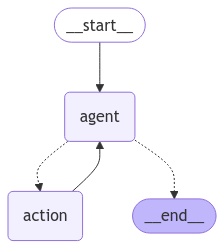

In [122]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [127]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="hi! I'm Jane Doe")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
input_message = HumanMessage(content="What are some products I purchased?")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print() 
    
input_message = HumanMessage(content="Can you suggest products based on my previous purchase?")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print() 

================================ Human Message =================================

hi! I'm Jane Doe
================================== Ai Message ==================================

Hi Jane Doe! How can I help you today?
================================ Human Message =================================

What are some products I purchased?
================================== Ai Message ==================================

I will search for products purchased by Jane Doe.
Tool Calls:
  retrieve_products_customers (6efdd12aa2c64c028b6b9e22e8781913)
 Call ID: 6efdd12aa2c64c028b6b9e22e8781913
  Args:
    query: Jane Doe
================================= Tool Message =================================
Name: retrieve_products_customers

## Customer_Info

First Name: Jane 
Last Name: Doe 
Age: 28 
Email Address: janedoe@example.com 
Phone Number: 555-987-6543 
Shipping Address: 456 Oak St, Another City USA, 67890 
Membership: Gold 

## Recent_Purchases

order_number: 6 
date: 2023-01-10 
item:
- des

#### Agentic RAG with Langgraph

In [196]:
# Agent state: A list of messages

from typing import Annotated, Literal, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [215]:
from langchain import hub
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.prebuilt import tools_condition
from langchain_openai import AzureChatOpenAI

### Edges

def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    # model = AzureChatOpenAI(model="gpt-4o", temperature=0, streaming=True)
    model = ChatCohere(model="command-r-plus-08-2024", temperature=0, streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    # score = scored_result.binary_score
    score = scored_result["binary_score"]

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = AzureChatOpenAI(model="gpt-4o", temperature=0, streaming=True)
    # model = ChatCohere(model="command-r-plus-08-2024", temperature=0, streaming=True)
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    # model = AzureChatOpenAI(model="gpt-4o", temperature=0, streaming=True)
    model = ChatCohere(model="command-r-plus-08-2024", temperature=0, streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    # llm = AzureChatOpenAI(model="gpt-4o", temperature=0, streaming=True)
    model = ChatCohere(model="command-r-plus-08-2024", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [216]:
## Generate the graph

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

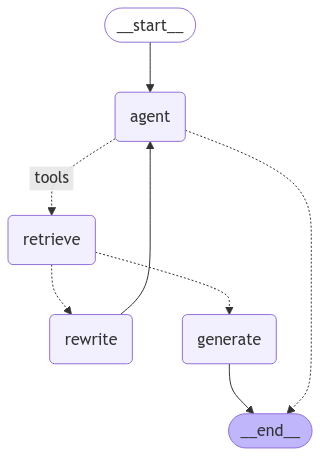

In [132]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [217]:
import pprint

inputs = {
    "messages": [
        # ("user", "What products were purchased by Jane Doe?"),
        # ("user", "Suggest some products based on Jane Doe's purchase history?"),
        ("user", "What other products from the product catalogue might interest Jane Doe from purchase history?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_hBsnksFrGO5m0PY6CFD8Geuv', 'function': {'arguments': '{"query":"Jane Doe purchase history"}', 'name': 'retrieve_products_customers'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_fa1dad0729'}, id='run-fa571629-869d-444e-827b-3fac7aae4705-0', tool_calls=[{'name': 'retrieve_products_customers', 'args': {'query': 'Jane Doe purchase history'}, 'id': 'call_hBsnksFrGO5m0PY6CFD8Geuv', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='## Customer_Info\n\nFirst Name: Jane \nLast Name: Doe \nAge: 28 \nEmail Address: janedoe@example.com \nPhone Number: 555-987-6543 \nShipping Address: 456 Oak St, Another City USA, 67890 \nMembership: Gold \n\n## Re